In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available():
    print(f"CUDA available. Using device \"{torch.cuda.get_device_name()}\".")
else:
    print(f"CUDA not available.")

CUDA available. Using device "NVIDIA GeForce GTX 1650 with Max-Q Design".


In [2]:
import numpy.typing as npt
from typing import Callable

class SimpleSolver(nn.Module):
    def __init__(self, size=25, length=10):
        super(SimpleSolver, self).__init__()
        # self.flatten = nn.Flatten()
        self.size = size
        self.length = length

        self.mlp = nn.Sequential(
            nn.Linear(3*size, 6*size),
            nn.ReLU(),
            nn.Linear(6*size,2*size)
        ).to(device)

#     def _cmplx_to_real(self, z):
#         assert list(z.shape) == [self.size]
#         return torch.cat(z.real(), z.imag())

#     def _real_to_cmplx(self, x):
#         assert list(x.shape) == [self.size*2]
#         real = x[0:self.size]
#         imag = x[self.size:2*self.size]
#         return torch.complex(real, imag)

    def forward(self, x):
        outs = self.mlp(x)
        return outs
    
    # take outside
#     def train(self, x, y, optimizer):


#         return loss, output
    
    # TODO this logic can be moved to dataset
#     def train(self,
#               wavefn: Callable[[npt.NDArray[np.double]], npt.NDArray[np.cdouble]],   # position => complex no
#               potential: Callable[[npt.NDArray[np.double]], npt.NDArray[np.double]], # position => real no
#               optimiser
#              ):
        
#         # idk why i need this?
#         self.zero_grad()
        
#         # Generate input vector from input wavefunction
#         xs = np.linspace(0,self.length,self.size)
#         psis = wavefn(xs)
#         vs = potential(xs)
#         nn_in = torch.cat(_cmplx_to_real(psis), vs)
        
#         # Feed through network to get d(psi)
#         nn_out = model(nn_in)
#         output_psi = _cmplx_to_real(nn_out)
        
#         # Calculate H(psi) so we can estimate loss fn
        
#         # Use formula f''(x) = [f(x+h) - 2f(x) + f(x-h)]/h^2.
#         h = self.size / self.length / 10  # h = 0.1 * dx
#         fx = wavefn(xs)
#         fxmh = wavefn(xs-h)
#         fxph = wavefn(xs+h)
#         fxmh[0] = 0          # enforce psi(x) = 0 outside of region
#         fxph[-1] = 0
        
#         lplc = (fxph - 2*fx + fxmh)/(h**2)
#         Hpsi = -0.5*lplc + vs*psis
        
#         loss_arr = torch.abs(1j * output_psi - Hpsi)
#         loss = torch.dot(loss_arr, loss_arr)
        
#         loss.backward()
        
#         optimiser.step() # voodoo shit - wtf im not even passing it anything
        
#         return loss, nn_out

In [3]:
class Schrodinger1DDataset(torch.utils.data.Dataset):
    def __init__(self, size=25, length=10, nums=1000):
        self.size = size
        self.length = length
        self.modes = 5
        self.nums = nums
        
        self.data = []
        for i in range(nums):
            self.data.append(self._generate_data_())
        
    def _cmplx_to_real(self, z):
        assert list(z.shape) == [self.size]
        #print(f'{str(z.shape)} is {str(self.size)}')
        return torch.cat((z.real, z.imag))

    def _real_to_cmplx(self, x):
        assert list(x.shape) == [self.size*2]
        real = x[0:self.size]
        imag = x[self.size:2*self.size]
        return torch.complex(real, imag)
        
    def __len__(self):
        return self.nums
    
    def __getitem__(self, index):    
        return self.data[index]
        
    def _generate_data_(self):
        cffs1 = torch.rand(self.modes) + 1j*torch.rand(self.modes)
        wavefn = lambda x: torch.sum(torch.outer(cffs1,torch.ones(len(xs)))*torch.sin(torch.outer(torch.arange(0,self.modes),xs)*np.pi/self.length), dim=0)
        
        cffs2 = torch.rand(self.modes)
        #potential = lambda x: torch.sum(torch.outer(cffs2,torch.ones(len(xs)))*torch.sin(torch.outer(torch.arange(0,self.modes),xs)*np.pi/self.length), dim=0)
        potential = lambda x: 0*x
        
        xs = torch.linspace(0,self.length,self.size)
        psis = wavefn(xs)
        vs = potential(xs)
        nn_in = torch.cat((self._cmplx_to_real(psis), vs))
        
        # Calculate H(psi) so we can estimate loss fn
        
        # Use formula f''(x) = [f(x+h) - 2f(x) + f(x-h)]/h^2.
        h = self.length / self.size / 10  # h = 0.1 * dx
        fx = wavefn(xs)
        fxmh = wavefn(xs-h)
        fxph = wavefn(xs+h)
        fxmh[0] = 0          # enforce psi(x) = 0 outside of region
        fxph[-1] = 0
        
        lplc = (fxph - 2*fx + fxmh)/(h**2)
        Hpsi = -0.5*lplc + vs*psis
        
        nn_out_expect = self._cmplx_to_real(Hpsi / 1j)
        
        return nn_in, nn_out_expect

In [4]:
# Try to train
# Should I be doing this or should I be using equiv of keras built in fns

from tqdm import tqdm

EPOCHS = 100
#LEARNS_PER_EPOCH = 2000

model = SimpleSolver(25,10)
data = Schrodinger1DDataset(25,10,1000)
train_data_loader = torch.utils.data.DataLoader(data, batch_size=20, shuffle=True)

optm = torch.optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(EPOCHS):
    epoch_loss = 0
    
    for x,y in train_data_loader:
        x = x.to(device)
        y = y.to(device)
        
        optm.zero_grad()
        output = model(x)
        loss = F.mse_loss(output,y)
        loss.backward()
        optm.step()
        
        epoch_loss+=loss
        
    print('Epoch {} Loss : {}'.format((epoch+1),epoch_loss))

Epoch 1 Loss : 0.19946959614753723
Epoch 2 Loss : 0.011715981177985668
Epoch 3 Loss : 0.005848337896168232
Epoch 4 Loss : 0.0036796419881284237
Epoch 5 Loss : 0.0024668327532708645
Epoch 6 Loss : 0.0016329382779076695
Epoch 7 Loss : 0.0010861989576369524
Epoch 8 Loss : 0.0007150500896386802
Epoch 9 Loss : 0.0004487312980927527
Epoch 10 Loss : 0.0002927333989646286
Epoch 11 Loss : 0.00019740310381166637
Epoch 12 Loss : 0.000134581423480995
Epoch 13 Loss : 0.00010341031884308904
Epoch 14 Loss : 7.931285654194653e-05
Epoch 15 Loss : 6.450420914916322e-05
Epoch 16 Loss : 5.03850715176668e-05
Epoch 17 Loss : 4.119165532756597e-05
Epoch 18 Loss : 3.404471499379724e-05
Epoch 19 Loss : 2.8977809051866643e-05
Epoch 20 Loss : 2.481438968970906e-05
Epoch 21 Loss : 2.2132124286144972e-05
Epoch 22 Loss : 1.8857428585761227e-05
Epoch 23 Loss : 1.646424425416626e-05
Epoch 24 Loss : 1.483328924223315e-05
Epoch 25 Loss : 1.2980228348169476e-05
Epoch 26 Loss : 1.2033997336402535e-05
Epoch 27 Loss : 1.13

In [5]:
%matplotlib notebook

import scipy.integrate
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Trial evolution of certain states

dt = 0.05
steps = 400
size = model.size
length = model.length

def _cmplx_to_real(z):
    return torch.cat((z.real, z.imag))

def _real_to_cmplx(x):
    real = x[0:size]
    imag = x[size:2*size]
    return torch.complex(real, imag)

ts = np.arange(0,dt*steps,dt)

def test_model(psi0, v):
    # Solve using traditional numerical methods
    N = 100
    dx = length / N
    xs_num = np.linspace(0,length,N)
    D2 = -2*np.eye(N)
    for i in range(N-1):
        D2[i,i+1] = 1
        D2[i+1,i] = 1
    H = -0.5*D2/(dx**2) + np.diag(v(xs_num))
    
    sol = scipy.integrate.solve_ivp(lambda t,p: H@p / 1j, t_span=[0,dt*steps], y0=psi0(xs_num)*(1+0j), t_eval=ts, method="RK23")
    
    num_model = sol.y
    
    # Solve using our method
    xs = torch.linspace(0,length,size)
    psi_latest = (psi0(xs)*(1+0j)).to(device)
    nn_model = [np.array(psi0(xs))]
    for i in range(steps):
        vs = v(xs).to(device)
        nn_in = torch.cat((_cmplx_to_real(psi_latest), vs)).to(device)
        nn_out = model.forward(nn_in)
        dpsi = _real_to_cmplx(nn_out)
        
        new_psi = psi_latest + dpsi * dt
        psi_latest = new_psi
        nn_model.append(psi_latest.cpu().detach().numpy())
        
    # Plot animations
    fig = plt.figure(figsize=(12,8))
    
    plt.rcParams["animation.html"] = "html5"
    plt.rcParams["figure.dpi"] = 75
    
    sbp1 = plt.subplot(2,2,1)
    sbp1.title.set_text('Our model')
    sbp1.set_xlim(0,length)
    sbp1.set_ylim(-1,1)
    l1, = sbp1.plot([],[], lw=2)
    
    sbp3 = plt.subplot(2,2,3)
    sbp3.set_xlim(0,length)
    sbp3.set_ylim(-1*np.pi,np.pi)
    l3, = sbp3.plot([],[], lw=2)
    
    sbp2 = plt.subplot(2,2,2)
    sbp2.title.set_text('Traditional model')
    sbp2.set_xlim(0,length)
    sbp2.set_ylim(-1,1)
    l2, = sbp2.plot([],[], lw=2)
    
    sbp4 = plt.subplot(2,2,4)
    sbp4.set_xlim(0,length)
    sbp4.set_ylim(-1*np.pi,np.pi)
    l4, = sbp4.plot([],[], lw=2)
    
    def animate(i):
        l1.set_data(xs, np.abs(nn_model[i]))
        l3.set_data(xs, np.angle(nn_model[i]))
        
        l2.set_data(xs_num, np.abs(num_model[:,i]))
        l4.set_data(xs_num, np.angle(num_model[:,i]))
        return [l1,l2]
    
    anim = animation.FuncAnimation(fig, animate, frames=steps, interval=20, blit=True)
    
    HTML(anim.to_html5_video())
    
    return anim
    

<IPython.core.display.Javascript object>


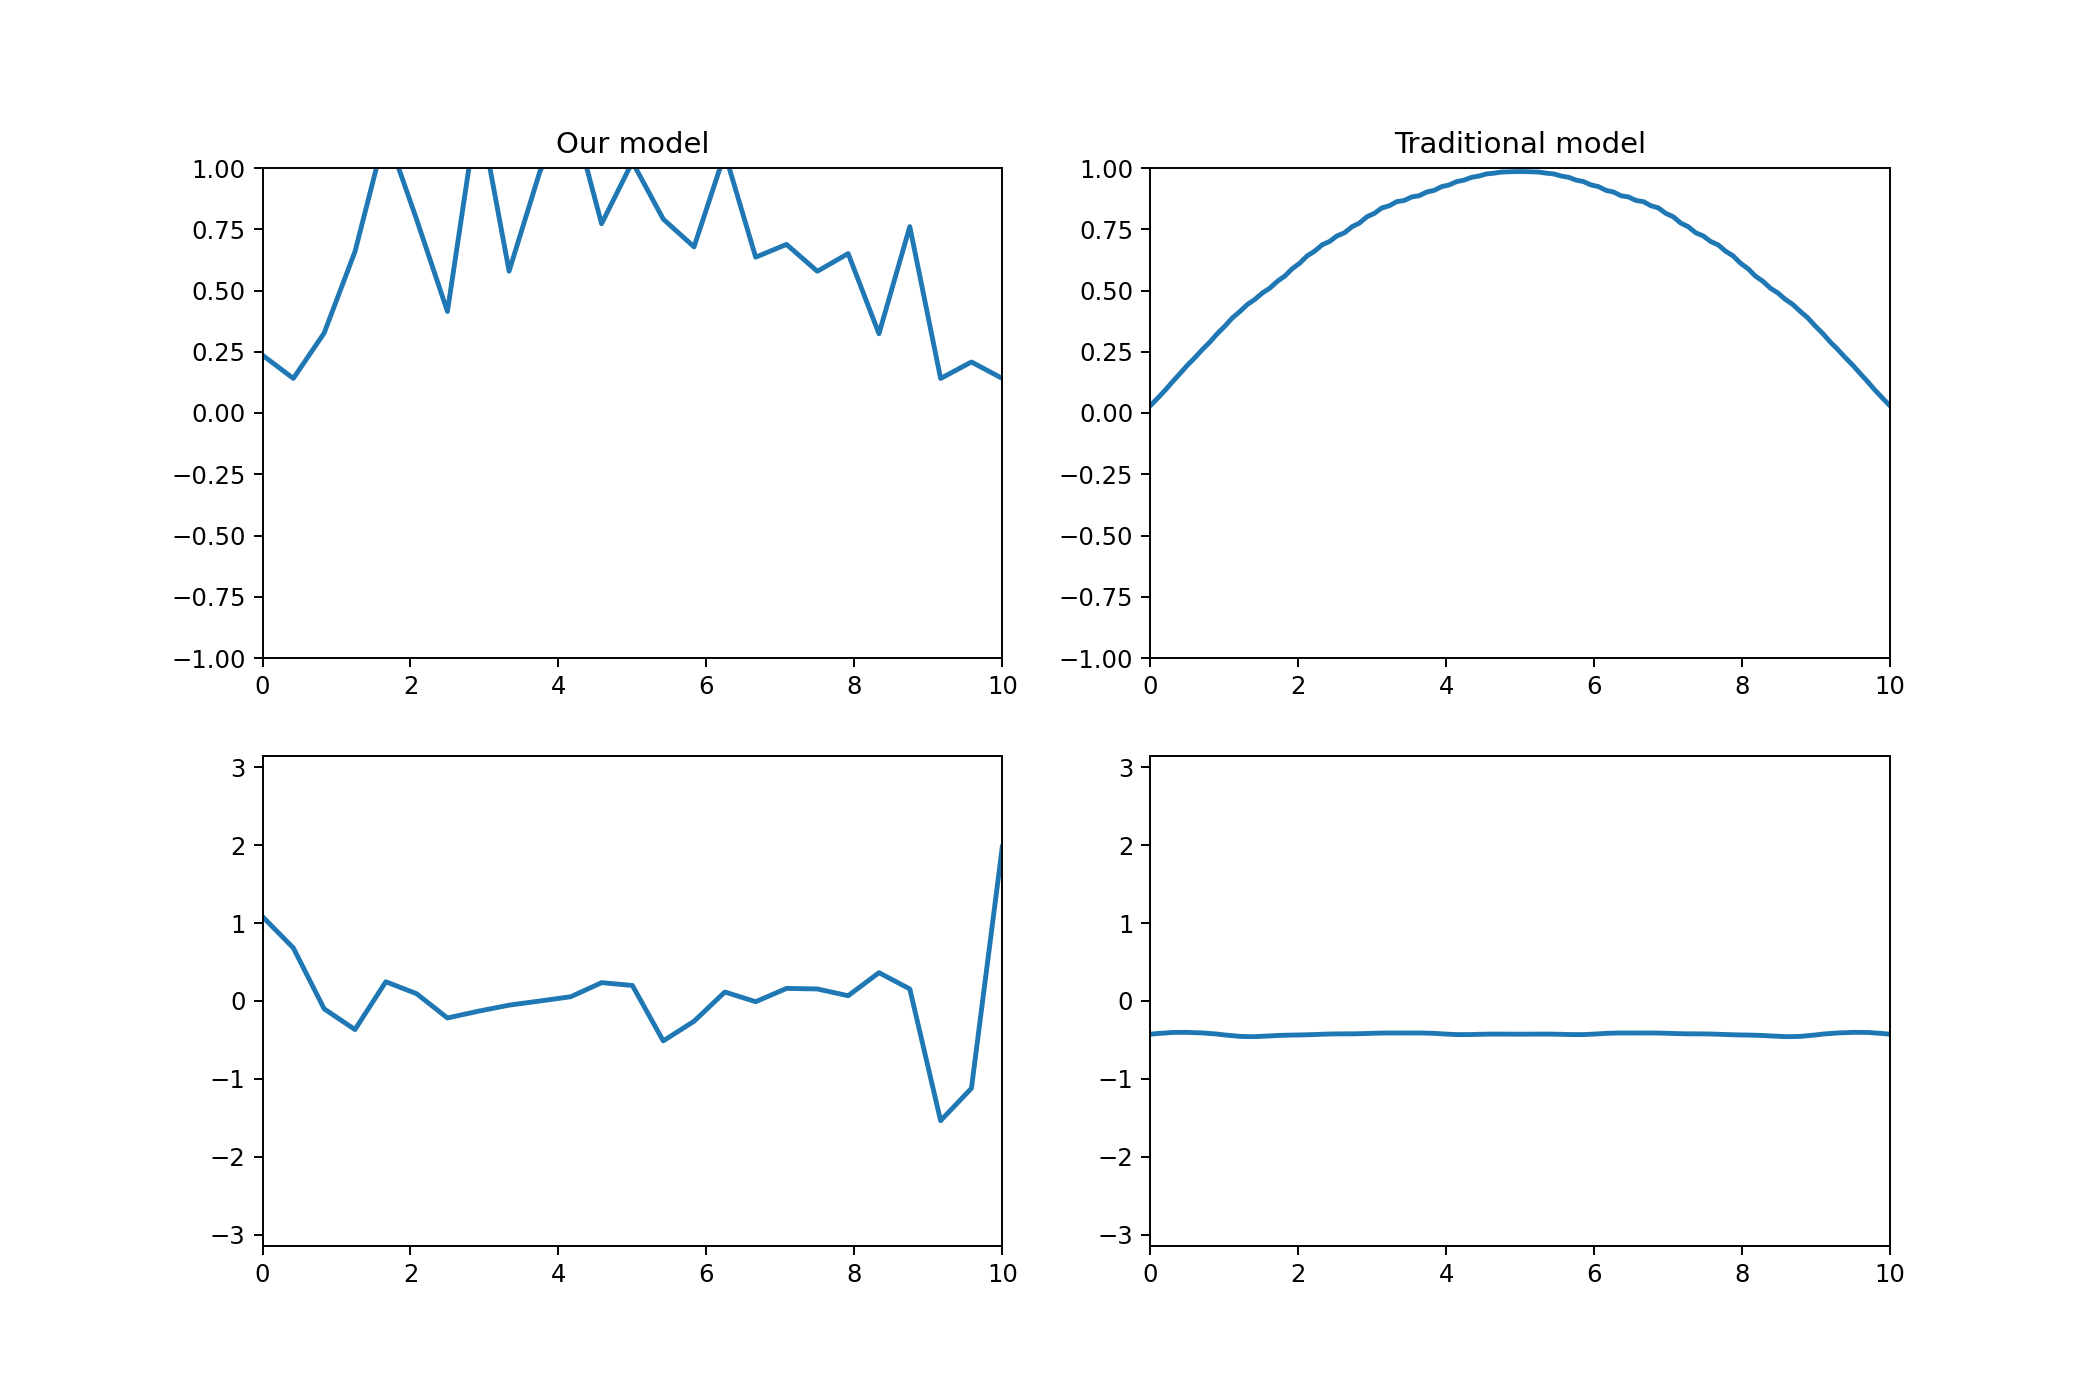

In [6]:
# Particle in a box eigenstate
test_model(lambda x: np.sin(np.pi*x/10), lambda x: 0*x)

<IPython.core.display.Javascript object>


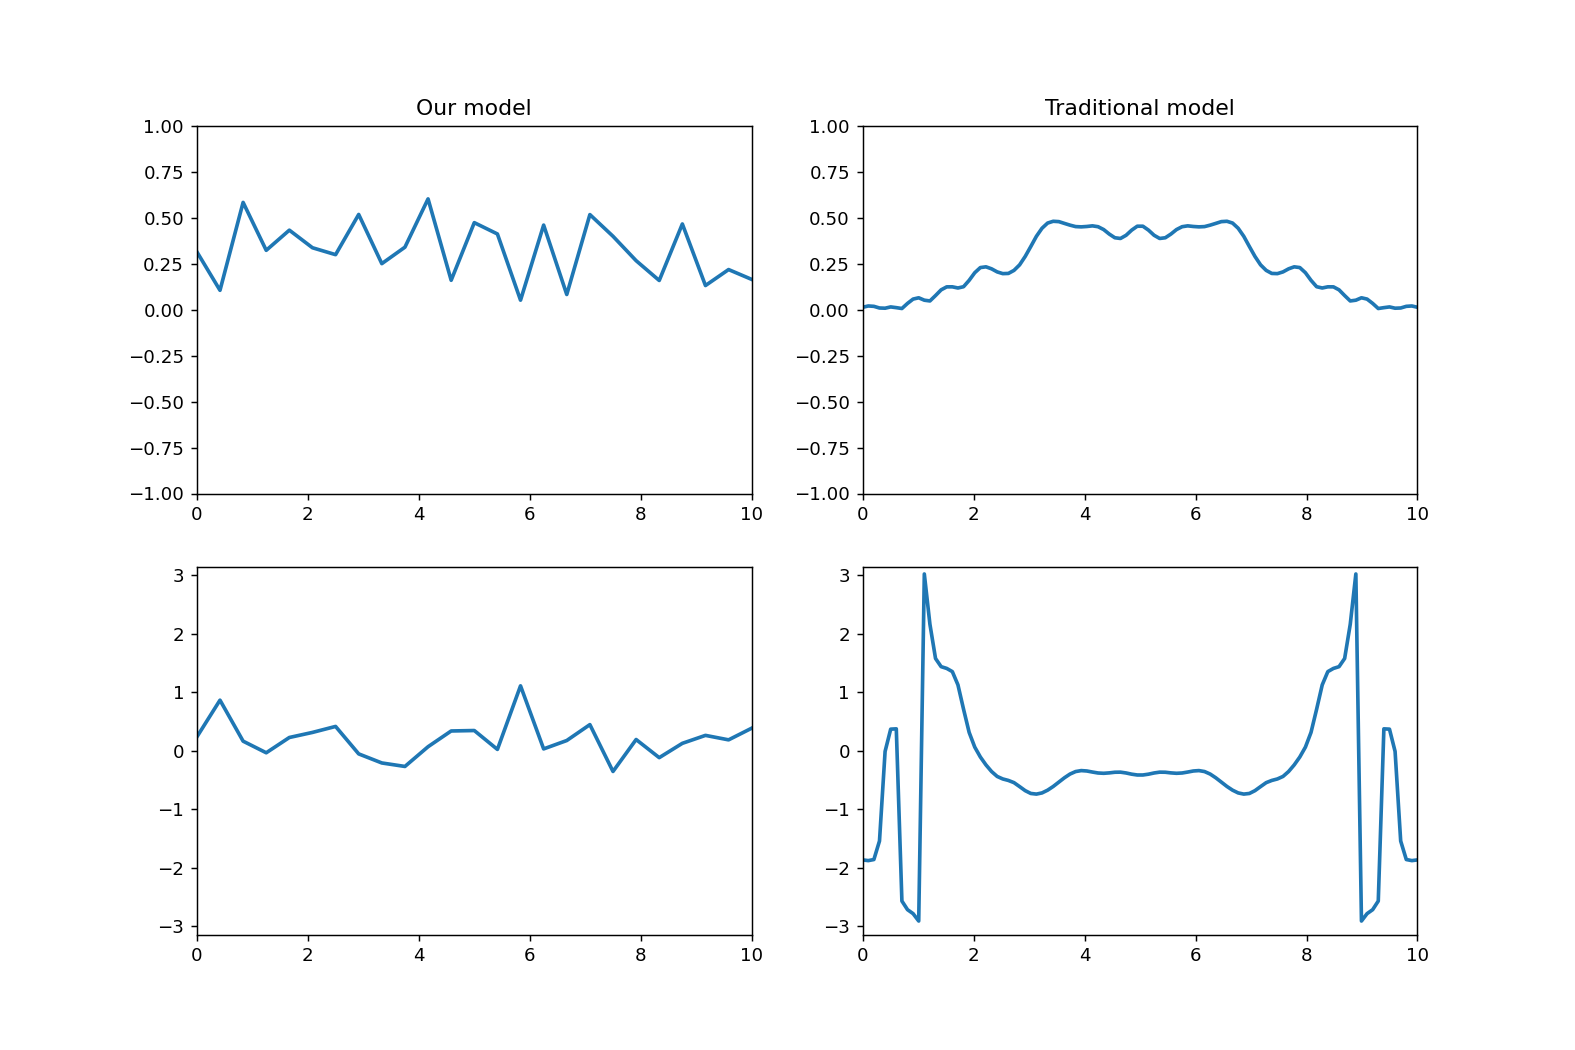

In [7]:
# Particle in a box flat
test_model(lambda x: 0.3+0*x, lambda x: 0*x)

<IPython.core.display.Javascript object>


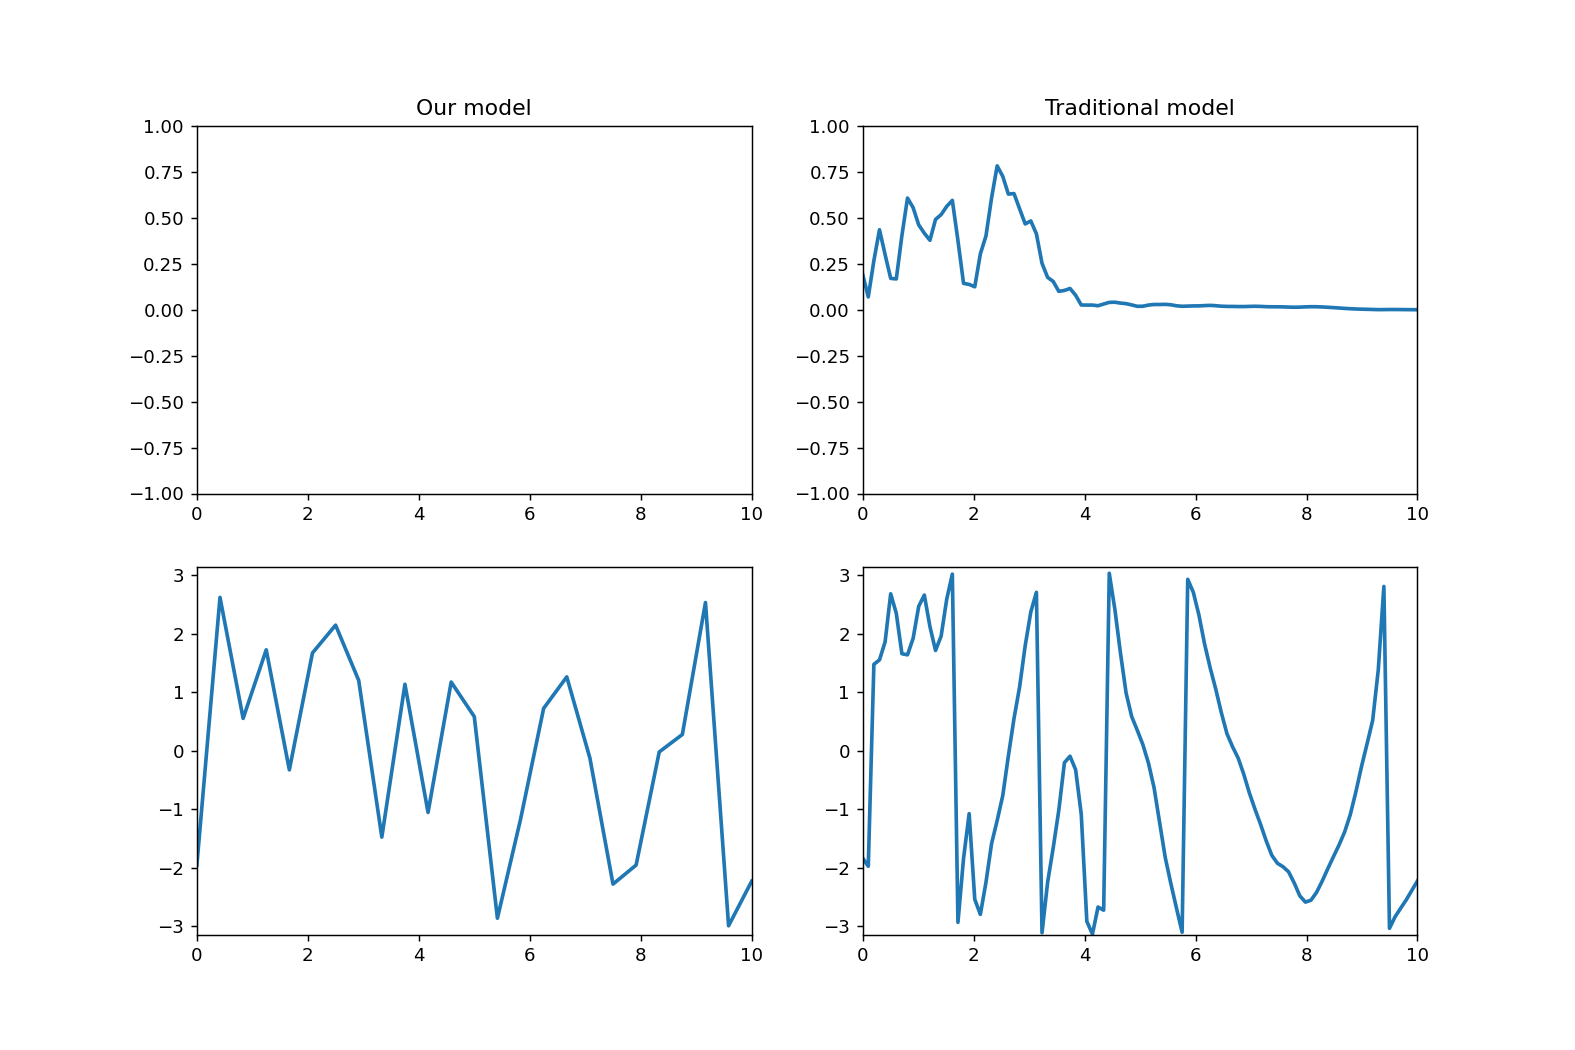

In [8]:
# Particle in a harmonic trap
test_model(lambda x: 0.3+0*x, lambda x: x**2)

In [9]:
N=8

D2 = -2*np.eye(N)
for i in range(N-1):
    D2[i,i+1] = 1
    D2[i+1,i] = 1
    
D2

array([[-2.,  1., -0., -0., -0., -0., -0., -0.],
       [ 1., -2.,  1., -0., -0., -0., -0., -0.],
       [-0.,  1., -2.,  1., -0., -0., -0., -0.],
       [-0., -0.,  1., -2.,  1., -0., -0., -0.],
       [-0., -0., -0.,  1., -2.,  1., -0., -0.],
       [-0., -0., -0., -0.,  1., -2.,  1., -0.],
       [-0., -0., -0., -0., -0.,  1., -2.,  1.],
       [-0., -0., -0., -0., -0., -0.,  1., -2.]])